In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
keras.__version__

'2.2.2'

## SP500 data

In [4]:
prices_dataset_train =  pd.read_csv('data/SP500_train.csv')     # 1258
prices_dataset_test =  pd.read_csv('data/SP500_test.csv')       #   20

trainingset = prices_dataset_train['adj_close'].values.reshape(-1,1)
testset = prices_dataset_test['adj_close'].values.reshape(-1,1)
print(trainingset.shape)
print(testset.shape)

(1258, 1)
(20, 1)


In [5]:
# min-max normalization
min_max_scaler = MinMaxScaler(feature_range=(0,1))
scaled_trainingset = min_max_scaler.fit_transform(trainingset)

In [6]:
scaled_trainingset[40]

array([0.09755084])

In [7]:
scaled_trainingset[40,0]

0.09755083705434409

In [8]:
# time series 에서 앞의 40개 값(X)을 가지고 41번째 값(y)을 예측
X_train = []
y_train = []

# X             y
# 0 - 39        40
# 1 - 40        41
interval = 40
for i in range(interval, trainingset.shape[0]):
    # use the previous 40 prices in order to forecast the next one
    X_train.append(scaled_trainingset[i-interval:i,0])
    # indexes start with 0 so this is the target (the price tomorrow)
    y_train.append(scaled_trainingset[i,0])

X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)

(1218, 40)


In [9]:
# input shape for LSTM architecture
# reshape the dataset (numOfSamples, numOfFeatures, 1)
# 1 : want to predict the price tomorrow (so 1 value)
# numOfFeatures: the past prices we use as features

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1218, 40, 1)


In [10]:
X_train[0].shape

(40, 1)

In [11]:
# BUILDING THE LSTM MODEL ----------------

In [12]:
# return sequence true because we have another LSTM after this one

model = Sequential()

model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # (40, 1)
model.add(Dropout(0.5))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50))
model.add(Dropout(0.3))

model.add(Dense(units=1))

In [13]:
# RMSProp is working fine with LSTM but so do ADAM optimizer
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=1000, batch_size=128, verbose=0)

In [14]:
# TESTING THE ALGORITHM ----------------

In [15]:
# training set + test set = 1258 + 20 = 1278 columns
dataset_total = pd.concat((prices_dataset_train['adj_close'], prices_dataset_test['adj_close']), axis=0) # 0: vertical
dataset_total.shape

(1278,)

In [16]:
# 1278 - 20 - 40
print( len(dataset_total)-len(prices_dataset_test)-interval )

1218


In [17]:
# all inputs for test set
inputs = dataset_total[len(dataset_total)-len(prices_dataset_test)-interval:].values
inputs = inputs.reshape(-1,1)
inputs = min_max_scaler.transform(inputs)

print(inputs.shape)

(60, 1)


In [18]:
X_test = []

for i in range(interval, len(prices_dataset_test)+interval):
    X_test.append(inputs[i-interval:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(20, 40, 1)


In [19]:
predictions = model.predict(X_test)
print(predictions.shape)

(20, 1)


In [20]:
# inverse the predicitons because we applied normalization but we want to compare with the original prices

predictions = min_max_scaler.inverse_transform(predictions)

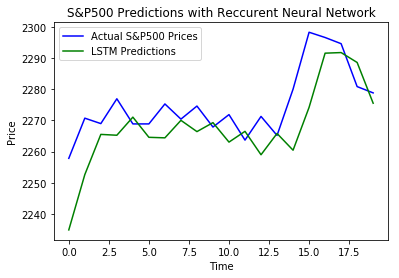

In [21]:
# plotting the results
plt.plot(testset, color='blue', label='Actual S&P500 Prices')
plt.plot(predictions, color='green', label='LSTM Predictions')
plt.title('S&P500 Predictions with Reccurent Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()